# Imports

In [60]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

df = pd.read_csv("C:\\Users\\slau2\\Change.org\\base_english_language_petition_metadata_20250615.csv")
df = df[df.user_country_code.isin(["US", "CA", "GB"])]

df["createdAt"] = pd.to_datetime(df["createdAt"])

# Time Series Visualization

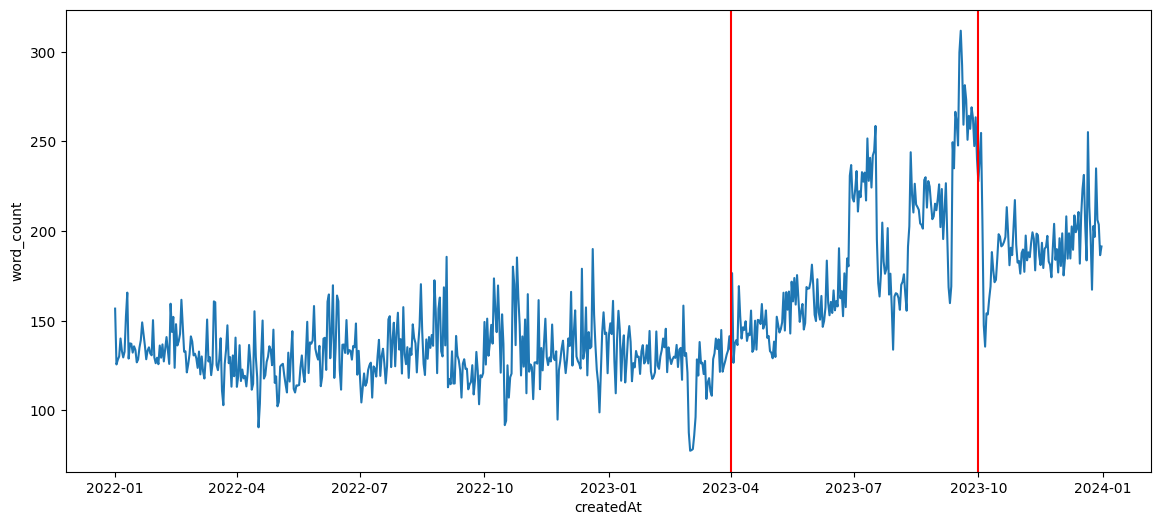

In [ ]:
plt.figure(figsize=(14, 6))

daily_wordcount = df.groupby(df["createdAt"].dt.date)["word_count"].mean().reset_index()
df = df.sort_values("createdAt")

sns.lineplot(data = daily_wordcount, x = "createdAt", y = "word_count")
plt.axvline(x = pd.to_datetime("2023-04-01"), color = "red") 
plt.axvline(x = pd.to_datetime("2023-10-01"), color = "red") 

In [68]:
df["createdAt_date"] = pd.to_datetime(df["createdAt_date"])
pre_ai = df[df.createdAt_date < pd.to_datetime("2023-04-01")]

mean_pre = pre_ai.word_count.mean()
median_pre = pre_ai.word_count.median()
sd_pre = pre_ai.word_count.std()

print(mean_pre)
print(median_pre)
print(sd_pre)

114.36265345495721
66.0
139.74147671385708


In [67]:
df["createdAt_date"] = pd.to_datetime(df["createdAt_date"])
mid_ai = df[(df.createdAt_date < pd.to_datetime("2023-10-01")) & (df.createdAt_date > pd.to_datetime("2023-04-01"))]

mean_mid = mid_ai.word_count.mean()
median_mid = mid_ai.word_count.median()
sd_mid = mid_ai.word_count.std()

print(mean_mid)
print(median_mid)
print(sd_mid)

168.6832425557231
109.0
169.5998524525508


In [69]:
df["createdAt_date"] = pd.to_datetime(df["createdAt_date"])
post_ai = df[df.createdAt_date > pd.to_datetime("2023-10-01")]

mean_post = post_ai.word_count.mean()
median_post = post_ai.word_count.median()
sd_post = post_ai.word_count.std()

print(mean_post)
print(median_post)
print(sd_post)

176.49961994971642
175.0
137.00523003193746


# Categorical Time Visualization


In [64]:
df['period'] = np.where(
    pd.to_datetime(df['createdAt_date']) < pd.to_datetime("2023-04-01"), 'pre',
    np.where(pd.to_datetime(df['createdAt_date']) > pd.to_datetime("2023-10-01"), 'post', 'mid')
)

df[['createdAt_date', 'period']]

,createdAt_date,period
395334,2022-01-01,pre
279917,2022-01-01,pre
270366,2022-01-01,pre
174156,2022-01-01,pre
197985,2022-01-01,pre
...,...,...
206495,2023-12-31,post
336558,2023-12-31,post
277988,2023-12-31,post
394689,2023-12-31,post


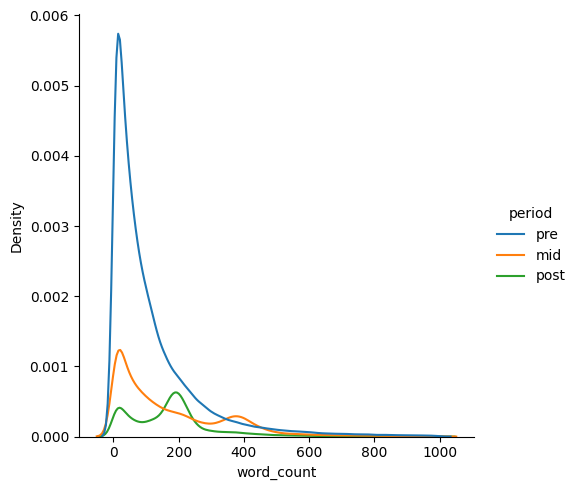

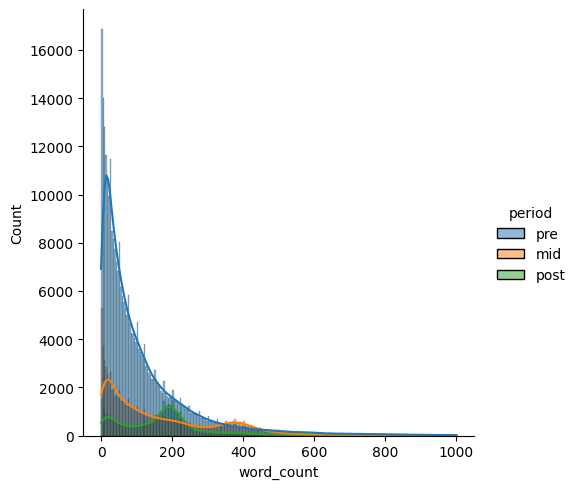

In [65]:
df = df[df['word_count'] <= 1000]
sns.displot(data = df, x = "word_count", kind = "kde", hue = "period")
sns.displot(data = df, x="word_count", hue = "period", kde = "true")

<Axes: xlabel='period', ylabel='word_count'>

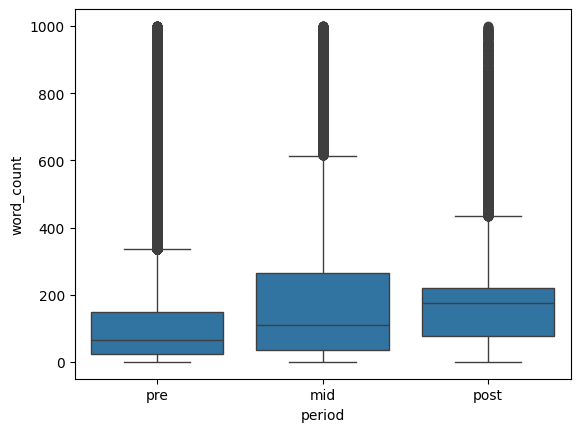

In [ ]:
sns.boxplot(data=df, x="period", y="word_count")

In [ ]:
print(df[df["period"] == "pre"]["word_count"].mean())
print(df[df["period"] == "pre"]["word_count"].median())
print(df[df["period"] == "pre"]["word_count"].std())

114.36265345495721
66.0
139.74147671385708


In [ ]:
print(df[df["period"] == "mid"]["word_count"].mean())
print(df[df["period"] == "mid"]["word_count"].median())
print(df[df["period"] == "mid"]["word_count"].std())

168.79046124246872
109.0
169.5947828028775


In [ ]:
print(df[df["period"] == "post"]["word_count"].mean())
print(df[df["period"] == "post"]["word_count"].median())
print(df[df["period"] == "post"]["word_count"].std())

176.49961994971642
175.0
137.00523003193746


# Ordinary Least Squares Regression Model


In [ ]:
df = pd.read_csv("C:\\Users\\slau2\\Change.org\\base_english_language_petition_metadata_20250615.csv")
df['period'] = np.where(
    pd.to_datetime(df['createdAt_date']) < pd.to_datetime("2023-04-01"), "pre",
    np.where(pd.to_datetime(df['createdAt_date']) > pd.to_datetime("2023-10-01"), "post", "mid")
)
df['has_decision_makers'] = np.where(df['has_decision_makers'] == True, 1, 0)
df['has_tags'] = np.where(df['has_tags'] == True, 1, 0)

df = pd.concat((df, pd.get_dummies(df['period'], drop_first = False)), axis = 1)

In [37]:
y = df["word_count"].to_numpy()
x1a = df["pre"].to_numpy()
x1b = df["mid"].to_numpy()
x1c = df["post"].to_numpy()
x2 = df["has_decision_makers"].to_numpy() 
x3 = df["has_tags"].to_numpy() 
x4 = df["signatureCount_total"].to_numpy()
x5 = df["english_ratio"].to_numpy()

x = np.column_stack((x1a, x1b, x1c, x2, x3, x4, x5))
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     3926.
Date:                Mon, 18 Aug 2025   Prob (F-statistic):               0.00
Time:                        23:01:12   Log-Likelihood:            -3.6070e+06
No. Observations:              524632   AIC:                         7.214e+06
Df Residuals:                  524625   BIC:                         7.214e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1184      2.607      1.580      0.1

# Gaussian Mixture Model

In [70]:
from sklearn.mixture import GaussianMixture

Q1 = df["word_count"].quantile(0.25)
Q3 = df["word_count"].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df = df[(df["word_count"] >= lower) & (df["word_count"] <= upper)]

X = df[df.period == "pre"]["word_count"].to_numpy()
X = X.reshape(-1, 1)
Y = df[df.period == "mid"]["word_count"].to_numpy()
Y = Y.reshape(-1,1)
Z = df[df.period == "post"]["word_count"].to_numpy()
Z = Z.reshape(-1,1)
A = df["word_count"].to_numpy()
A = A.reshape(-1,1)

gmX = GaussianMixture(n_components = 2, random_state = 0).fit(X)
gmX.means_


array([[174.49262388],
       [ 37.74448242]])

In [59]:
gmY = GaussianMixture(n_components = 2, random_state = 0).fit(Y)
gmY.means_

array([[234.61683018],
       [ 42.37494935]])

In [51]:
gmZ = GaussianMixture(n_components = 2, random_state = 0).fit(Z)
gmZ.means_

array([[ 24.81888313],
       [183.50883503]])

In [52]:
gmA = GaussianMixture(n_components = 2, random_state = 0).fit(A)
gmA.means_

array([[167.74566867],
       [ 32.44629255]])